In [106]:
import pandas as pd
import numpy as np
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from xgboost import XGBRegressor
import xgboost
from sklearn.svm import SVR
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error as mae
from keras.models import *
from keras.layers import Dense, Dropout
from keras.optimizers import Adam
from sklearn.ensemble import AdaBoostRegressor
import matplotlib.pyplot as plt
from sklearn.model_selection import RepeatedKFold,cross_val_score
from sklearn.ensemble import StackingRegressor

In [107]:
# Importation des jeux de données
train_df = pd.read_csv("certificatbigdata/train.csv",delimiter=",")
test_df = pd.read_csv("certificatbigdata/test.csv",delimiter=",")
store_df = pd.read_csv("certificatbigdata/store_metadata.csv",delimiter=",")

C:\Users\omabe\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3146: DtypeWarning: Columns (5) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [108]:
train_df

,id,date,customers,open,promo,state_holliday,school_holiday,y
0,1042,2013-01-01,0,0,0,a,1,0
1,128,2013-01-01,0,0,0,a,1,0
2,420,2013-01-01,0,0,0,a,1,0
3,225,2013-01-01,0,0,0,a,1,0
4,144,2013-01-01,0,0,0,a,1,0
...,...,...,...,...,...,...,...,...
813762,757,2015-07-31,684,1,1,0,1,9343
813763,796,2015-07-31,769,1,1,0,1,8913
813764,230,2015-07-31,1091,1,1,0,1,10988
813765,387,2015-07-31,1402,1,1,0,1,14533


In [109]:
store_df

,id,store_type,assortment,promo_interval
0,1,c,a,NaN
1,2,a,a,"Jan,Apr,Jul,Oct"
2,3,a,a,"Jan,Apr,Jul,Oct"
3,4,c,c,NaN
4,5,a,a,NaN
...,...,...,...,...
1110,1111,a,a,"Jan,Apr,Jul,Oct"
1111,1112,c,c,NaN
1112,1113,a,c,NaN
1113,1114,a,c,NaN


# DATA CLEANING

In [110]:
train_df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 813767 entries, 0 to 813766
Data columns (total 8 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   id              813767 non-null  int64 
 1   date            813767 non-null  object
 2   customers       813767 non-null  int64 
 3   open            813767 non-null  int64 
 4   promo           813767 non-null  int64 
 5   state_holliday  813767 non-null  object
 6   school_holiday  813767 non-null  int64 
 7   y               813767 non-null  int64 
dtypes: int64(6), object(2)
memory usage: 49.7+ MB


In [111]:
# On remarque que les données d'entrainement ne contiennent pas de valeurs NaN
train_df.isna().sum()

id                0
date              0
customers         0
open              0
promo             0
state_holliday    0
school_holiday    0
y                 0
dtype: int64

In [112]:
# Supprimer les données dupliquées
train_df = train_df.drop_duplicates()

In [113]:
print(f"unique open values :{train_df['open'].unique()}")
print(f"unique promo values :{train_df['promo'].unique()}")
print(f"unique state_holliday values :{train_df['state_holliday'].unique()}")
print(f"unique school_holiday values :{train_df['school_holiday'].unique()}")

unique open values :[0 1]
unique promo values :[0 1]
unique state_holliday values :['a' '0' 'b' 'c' 0]
unique school_holiday values :[1 0]


### state_holliday

In [114]:
# Observer les valeurs possibles de state_holliday
train_df['state_holliday'].value_counts()

0    761641
0     27335
a     16201
b      5322
c      3268
Name: state_holliday, dtype: int64

In [115]:
# Puisque state_holiday est binaire, on considère '0' , 0 => 0 et 'a','b','c' => 1
train_df['state_holliday'] = train_df['state_holliday'].apply(lambda x : 0 if str(x)=="0" else 1)
test_df['state_holliday'] = test_df['state_holliday'].apply(lambda x : 0 if str(x)=="0" else 1)

In [116]:
train_df['state_holliday'].value_counts()

0    788976
1     24791
Name: state_holliday, dtype: int64

### Open Var

In [117]:
# Voir si on dispose dans la base de données un magasin ouvert avec un volume des ventes positif
train_df[(train_df['open']==0) & (train_df['y']>0)]

,id,date,customers,open,promo,state_holliday,school_holiday,y


In [118]:
# Volume de ventes est toujours positif
train_df['y'].min()

0

In [119]:
test_df[(test_df['open']==0) & (test_df['y']>0)]

,id,date,customers,open,promo,state_holliday,school_holiday,y


In [120]:
test_df['y'].min()

0

In [121]:
# On déduit qu'on pourra nous en passer de l'input 'open' car quand ce n'est pas open la valeur y est nulle

#train_df = train_df.drop(columns=['open'])
#test_df = test_df.drop(columns=['open'])

In [122]:
# Vérifier si la variable Date ne prends pas des valeurs abérrantes

def chack_date(date):
  L = date.split('-')
  return len(L)==3 and len(L[0])==4 and len(L[1])==2 and len(L[2])==2
train_df['date'].apply(chack_date).value_counts()

True    813767
Name: date, dtype: int64

In [123]:
import seaborn as sns

<AxesSubplot:>

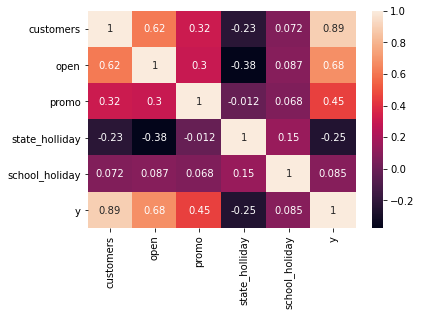

In [124]:
# Corrélation entre la variables; on remarque que le nombre de clients a une grande influence sur la nombre de ventes

sns.heatmap(train_df.drop(columns=['id']).corr(), annot=True)

In [125]:
# On remarque aussi qu'il y a une corrélation linéaire entre 'customers' et 'y'

#pd.plotting.scatter_matrix(train_df.drop(columns=['id','date']).sample(50000), alpha=0.2, figsize=(15,15))

## Store 

In [126]:
# Les valeurs possibles de 'store_type'

store_df['store_type'].value_counts()

a    602
d    348
c    148
b     17
Name: store_type, dtype: int64

In [127]:
# Les valeurs possibles de 'assortment'

store_df['assortment'].value_counts()

a    593
c    513
b      9
Name: assortment, dtype: int64

In [128]:
# Les valeurs possibles de 'promo_interval'

store_df['promo_interval'].value_counts()

Jan,Apr,Jul,Oct     335
Feb,May,Aug,Nov     130
Mar,Jun,Sept,Dec    106
Name: promo_interval, dtype: int64

In [129]:
train_df['promo'].value_counts()

0    503121
1    310646
Name: promo, dtype: int64

In [130]:
# Rajouter la variable y/customers

train_df['SalesPerCustomers'] = train_df['y'] / train_df['customers']

avg_store = train_df.groupby('id')[['y', 'customers', 'SalesPerCustomers']].mean()
avg_store.rename(columns=lambda x: 'Avg' + x, inplace=True)
store_df = pd.merge(avg_store.reset_index(), store_df, on='id')
store_df.head()

,id,Avgy,Avgcustomers,AvgSalesPerCustomers,store_type,assortment,promo_interval
0,1,3950.539370,467.883202,8.397500,c,a,NaN
1,2,4117.196078,485.605229,8.408104,a,a,"Jan,Apr,Jul,Oct"
2,3,5850.149194,630.470430,9.138877,a,a,"Jan,Apr,Jul,Oct"
3,4,8028.679245,1102.529650,7.243965,c,c,NaN
4,5,3873.781291,445.283267,8.609952,a,a,NaN


In [131]:
# Rajout de la variable dayofweek et dayofyear
train_df['day_of_week'] = pd.to_datetime(train_df['date']).dt.dayofweek
test_df['day_of_week'] = pd.to_datetime(test_df['date']).dt.dayofweek

train_df['day_of_year'] = pd.to_datetime(train_df['date']).dt.dayofyear
test_df['day_of_year'] = pd.to_datetime(test_df['date']).dt.dayofyear

train_df['week_of_year'] = pd.to_datetime(train_df['date']).dt.weekofyear
test_df['week_of_year'] = pd.to_datetime(test_df['date']).dt.weekofyear

# okay = train_df.groupby(['id','day_of_week'])['y'].agg(['mean']).copy()
# train_df = pd.merge(left = train_df , right = okay.reset_index(), on=['id','day_of_week'], how ='left')
# test_df = pd.merge(left = test_df, right = okay.reset_index(),on=['id','day_of_week'], how ='left')

train_df.head()

<ipython-input-131-df9ea89b12cf>:8: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  train_df['week_of_year'] = pd.to_datetime(train_df['date']).dt.weekofyear
<ipython-input-131-df9ea89b12cf>:9: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  test_df['week_of_year'] = pd.to_datetime(test_df['date']).dt.weekofyear


,id,date,customers,open,promo,state_holliday,school_holiday,y,SalesPerCustomers,day_of_week,day_of_year,week_of_year
0,1042,2013-01-01,0,0,0,1,1,0,NaN,1,1,1
1,128,2013-01-01,0,0,0,1,1,0,NaN,1,1,1
2,420,2013-01-01,0,0,0,1,1,0,NaN,1,1,1
3,225,2013-01-01,0,0,0,1,1,0,NaN,1,1,1
4,144,2013-01-01,0,0,0,1,1,0,NaN,1,1,1


In [132]:
#Ratio = y/customers byday_of_week
train_group = train_df.groupby(['id','day_of_week'])

ratio_df = pd.DataFrame({'ratio_by_day_of_week':train_group['y'].sum()/train_group['customers'].sum()})
customers_perday = pd.DataFrame({'CustomersPerDay':train_group['customers'].sum()})

train_df= pd.merge(left = train_df, right = ratio_df ,on=['id','day_of_week'], how ='left')
test_df = pd.merge(left = test_df, right = ratio_df,on=['id','day_of_week'], how ='left')

train_df= pd.merge(left = train_df, right = customers_perday ,on=['id','day_of_week'], how ='left')
test_df = pd.merge(left = test_df, right = customers_perday,on=['id','day_of_week'], how ='left')

#Rajout de app_y = ratio_by_dayofweek * customers
train_df['app_p'] = train_df['customers']*train_df['ratio_by_day_of_week']
test_df['app_p'] = test_df['customers']*test_df['ratio_by_day_of_week']

test_df

,id,date,customers,open,promo,state_holliday,school_holiday,y,day_of_week,day_of_year,week_of_year,ratio_by_day_of_week,CustomersPerDay,app_p
0,1105,2013-01-01,0,0,0,1,1,0,1,1,1,8.886458,53302,0.000000
1,306,2013-01-01,0,0,0,1,1,0,1,1,1,9.355798,42794,0.000000
2,1115,2013-01-01,0,0,0,1,1,0,1,1,1,14.573775,43355,0.000000
3,506,2013-01-01,0,0,0,1,1,0,1,1,1,9.022218,85560,0.000000
4,877,2013-01-01,0,0,0,1,1,0,1,1,1,7.372790,105188,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
203437,728,2015-07-31,542,1,1,0,1,0,4,212,31,11.468789,52610,6216.083748
203438,323,2015-07-31,716,1,1,0,1,0,4,212,31,11.870420,63891,8499.220673
203439,912,2015-07-31,806,1,1,0,1,0,4,212,31,7.555701,81229,6089.894644
203440,276,2015-07-31,575,1,1,0,1,0,4,212,31,7.808782,61537,4490.049482


In [133]:
# Remove points with 0 Sales
# Set Open = 0 when Sales = 0 OR Customers = 0
# train_df.loc[ (train_df['customers']==0) | (train_df['y']==0) , 'open' ] = 0
# train_df = train_df[train_df['open'] == 1]

In [134]:
pd.set_option('display.max_columns', None)

In [135]:
def build_features(train = train_df, store = store_df):
    # Convert string types into integers
    store['store_type'] = store['store_type'].astype('category').cat.codes
    store['assortment'] = store['assortment'].astype('category').cat.codes
    store['promo_interval'] = store['promo_interval'].astype('category').cat.codes
    train["state_holliday"] = train["state_holliday"].astype('category').cat.codes
    
    store['store_type'] = pd.to_numeric(store['store_type'])
    store['assortment'] = pd.to_numeric(store['assortment'])
    train['state_holliday'] = pd.to_numeric(train['state_holliday'])

    merged = pd.merge(train, store, on='id', how='left')
    
    # remove NaNs
    NaN_replace = 0
    merged.fillna(NaN_replace, inplace=True)
    
    #merged['day_of_week'] = pd.to_datetime(merged['date']).dt.dayofweek
    merged['Year'] = pd.to_datetime(merged['date']).dt.year
    merged['Month'] = pd.to_datetime(merged['date']).dt.month
    merged['Day'] = pd.to_datetime(merged['date']).dt.day
    merged['Week'] = pd.to_datetime(merged['date']).dt.week
    
    merged['Year'] = pd.to_numeric(merged['Year'])
    merged['Month'] = pd.to_numeric(merged['Month'])
    merged['Day'] = pd.to_numeric(merged['Day'])
    merged['Week'] = pd.to_numeric(merged['Week'])
    
    #merged = merged[merged['Month'] != 12] #Supprimer les valeurs du mois de Décembre

    return merged

med_store = train_df.groupby('id')[['y', 'customers', 'SalesPerCustomers']].median()
med_store.rename(columns=lambda x: 'Med' + x, inplace=True)

store_df = pd.merge(med_store.reset_index(), store_df, on='id')
features = build_features(train_df, store_df)
features

<ipython-input-135-f6b3fb7f2d17>:22: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  merged['Week'] = pd.to_datetime(merged['date']).dt.week


,id,date,customers,open,promo,state_holliday,school_holiday,y,SalesPerCustomers,day_of_week,day_of_year,week_of_year,ratio_by_day_of_week,CustomersPerDay,app_p,Medy,Medcustomers,MedSalesPerCustomers,Avgy,Avgcustomers,AvgSalesPerCustomers,store_type,assortment,promo_interval,Year,Month,Day,Week
0,1042,2013-01-01,0,0,0,1,1,0,0.000000,1,1,1,7.412280,62460,0.000000,3627.0,512.0,7.346963,3363.957839,446.072464,7.443203,0,0,0,2013,1,1,1
1,128,2013-01-01,0,0,0,1,1,0,0.000000,1,1,1,12.703947,64708,0.000000,6671.5,556.0,12.276435,6176.957143,492.961039,12.373707,3,2,1,2013,1,1,1
2,420,2013-01-01,0,0,0,1,1,0,0.000000,1,1,1,11.001093,31100,0.000000,4156.5,382.0,11.209468,3769.974832,334.003356,11.193422,3,2,1,2013,1,1,1
3,225,2013-01-01,0,0,0,1,1,0,0.000000,1,1,1,9.484903,57593,0.000000,4565.0,519.0,9.164230,4367.282993,467.165986,9.247951,3,0,-1,2013,1,1,1
4,144,2013-01-01,0,0,0,1,1,0,0.000000,1,1,1,10.635794,55098,0.000000,7030.0,691.0,10.433333,6343.254576,599.552413,10.508401,0,2,-1,2013,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
813762,757,2015-07-31,684,1,1,0,1,9343,13.659357,4,212,31,11.625640,51739,7951.937919,5527.0,501.0,11.425388,5095.916777,439.859974,11.482440,0,2,-1,2015,7,31,31
813763,796,2015-07-31,769,1,1,0,1,8913,11.590377,4,212,31,10.584014,66834,8139.106862,6426.0,645.0,10.737490,5960.280702,548.217274,10.767563,0,2,-1,2015,7,31,31
813764,230,2015-07-31,1091,1,1,0,1,10988,10.071494,4,212,31,8.097225,101774,8834.072720,6948.0,896.0,7.904656,6305.500666,783.585885,7.973675,3,2,-1,2015,7,31,31
813765,387,2015-07-31,1402,1,1,0,1,14533,10.365906,4,212,31,7.753565,118376,10870.498006,7784.0,1094.0,7.587732,7561.992011,963.762983,7.727806,2,0,2,2015,7,31,31


In [136]:
#Remove outliers

# def reject_outliers(df,col_name, m=2.6):
#     return df[ (df[col_name] - df[col_name].mean()).abs() < m * df[col_name].std()]

# features = pd.concat([reject_outliers(df,'SalesPerCustomers') for ID,df in features.groupby(['id'])])
# features = features.sort_index()

# features

In [137]:
X = [
    'id', 
    'customers',
    'promo',
    #'promo_interval',
    
    #'school_holiday',
    'state_holliday',
    'store_type',
    'assortment',

    'Avgy',
    'Avgcustomers',
    'AvgSalesPerCustomers',
    
    'Medy',
    'Medcustomers',
    'MedSalesPerCustomers',

    'day_of_week',
    'day_of_year',
    'week_of_year',
    
    'Week',
    'Day',
    'Month',
    'Year',
    
    'ratio_by_day_of_week',
    'app_p',
    'CustomersPerDay',
]

X_train, X_valid, y_train, y_valid = train_test_split(
    features[X], features['y'], test_size=0.15, random_state=42)

X1 , y1 = features[X].copy(), features['y'].copy()

In [138]:
#Scaling
# scaler = StandardScaler()
# X_train = scaler.fit_transform(X_train)
# X_valid = scaler.transform(X_valid)

In [139]:
# Print input/target format 
print(f'Input shape  : {X1.shape}')
print(f'Target shape : {y1.shape}')
display(X1)

Input shape  : (813767, 22)
Target shape : (813767,)


,id,customers,promo,state_holliday,store_type,assortment,Avgy,Avgcustomers,AvgSalesPerCustomers,Medy,Medcustomers,MedSalesPerCustomers,day_of_week,day_of_year,week_of_year,Week,Day,Month,Year,ratio_by_day_of_week,app_p,CustomersPerDay
0,1042,0,0,1,0,0,3363.957839,446.072464,7.443203,3627.0,512.0,7.346963,1,1,1,1,1,1,2013,7.412280,0.000000,62460
1,128,0,0,1,3,2,6176.957143,492.961039,12.373707,6671.5,556.0,12.276435,1,1,1,1,1,1,2013,12.703947,0.000000,64708
2,420,0,0,1,3,2,3769.974832,334.003356,11.193422,4156.5,382.0,11.209468,1,1,1,1,1,1,2013,11.001093,0.000000,31100
3,225,0,0,1,3,0,4367.282993,467.165986,9.247951,4565.0,519.0,9.164230,1,1,1,1,1,1,2013,9.484903,0.000000,57593
4,144,0,0,1,0,2,6343.254576,599.552413,10.508401,7030.0,691.0,10.433333,1,1,1,1,1,1,2013,10.635794,0.000000,55098
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
813762,757,684,1,0,0,2,5095.916777,439.859974,11.482440,5527.0,501.0,11.425388,4,212,31,31,31,7,2015,11.625640,7951.937919,51739
813763,796,769,1,0,0,2,5960.280702,548.217274,10.767563,6426.0,645.0,10.737490,4,212,31,31,31,7,2015,10.584014,8139.106862,66834
813764,230,1091,1,0,3,2,6305.500666,783.585885,7.973675,6948.0,896.0,7.904656,4,212,31,31,31,7,2015,8.097225,8834.072720,101774
813765,387,1402,1,0,2,0,7561.992011,963.762983,7.727806,7784.0,1094.0,7.587732,4,212,31,31,31,7,2015,7.753565,10870.498006,118376


In [140]:
# Print Data size
print(f'Train size : {X_train.shape[0]}')
print(f'Validation size : {X_valid.shape[0]}')
#print(f'Test size : {X_test.shape[0]}')

Train size : 691701
Validation size : 122066


In [141]:
# Vérifier si X1 et test_df_new ne contient au final que des valeurs numériques

X1.apply(lambda s: pd.to_numeric(s, errors='coerce').notnull().all())
# test_df_new.apply(lambda s: pd.to_numeric(s, errors='coerce').notnull().all())

id                      True
customers               True
promo                   True
state_holliday          True
store_type              True
assortment              True
Avgy                    True
Avgcustomers            True
AvgSalesPerCustomers    True
Medy                    True
Medcustomers            True
MedSalesPerCustomers    True
day_of_week             True
day_of_year             True
week_of_year            True
Week                    True
Day                     True
Month                   True
Year                    True
ratio_by_day_of_week    True
app_p                   True
CustomersPerDay         True
dtype: bool

## Remove Outliers

In [142]:
# #remove outliers
# train_nozero['ratio'] = train_nozero['y']/train_nozero['customers']
# def reject_outliers(df,col_name, m=1):
#     return df[ (df[col_name] - df[col_name].mean()).abs() < m * df[col_name].std()]

# train_nozero = pd.concat([reject_outliers(df,'ratio') for ID,df in train_nozero.groupby(['id'])])

In [ ]:
# train_nozero = train_nozero.sort_index()
# train_nozero = train_nozero.drop(columns=['ratio'])

# test_df_new

# Train Models Pipeline

In [ ]:
Models = dict()

In [ ]:
def train_model_grid_search(model_name, model, grid, train_data=(X_train,y_train), valid_data=(X_valid,y_valid),
                            eval_metric='neg_mean_absolute_error', save_dict=Models, verbose=1):
    """
    model_name : Name of the model
    model : sklearn model
    grid : Hyper parameters search grid
    train_data : (train inputs, train outputs)
    eval_metric : evaluation metric in the grid search
    ------------------
    Trains model on training data using a grid search and cross validation then saves trained model in save_dict
    """
    model_cv = GridSearchCV(model, grid, scoring=eval_metric, cv=5)
    model_cv.fit(X_train, y_train)
    train_preds, valid_preds = model_cv.predict(X_train) , model_cv.predict(X_valid)
    #train_preds, valid_preds = np.maximum(train_preds,0) , np.maximum(valid_preds,0)
    save_dict[model_name] = {'model':model_cv,
                             'scores':{'train': mae(y_train, train_preds),
                                       'valid' :mae(y_valid, valid_preds)
                                       }}
    if verbose ==1:
        print(f" -  {model_name} best hyperparameters : {model_cv.best_params_}",'\n\n')
        print(f" -  {model_name} results on the train set:" )
        print(mae(y_train, train_preds))
        print(f" -  {model_name} results on the valid set:")
        print(mae(y_valid, valid_preds))
        
def plot_importance(model):
    k = list(zip(X, model.feature_importances_))
    k.sort(key=lambda tup: tup[1])

    labels, vals = zip(*k)
    
    plt.barh(np.arange(len(X)), vals, align='center')
    plt.yticks(np.arange(len(X)), labels)
        

### Linear Regression

In [ ]:
train_model_grid_search(model_name = 'Linear Regression',
                        model = LinearRegression(),
                        grid = {'fit_intercept':[True,False], 
                                'copy_X':[True, False],
                                'normalize':[True,False]})


### Decision trees


In [ ]:
train_model_grid_search(model_name = 'Decision Tree Regression',
                        model = DecisionTreeRegressor(random_state = 42),
                        grid = {'max_depth':list(range(5,20,4)),'min_samples_leaf':range(1,20,2)
                                })

In [ ]:
model = Models['Decision Tree Regression']['model'].best_estimator_
plot_importance(model)

In [ ]:
train_model_grid_search(model_name = 'Ada Boost Decision Tree Regression',
                        model = AdaBoostRegressor(DecisionTreeRegressor(random_state = 42,max_depth=17,min_samples_leaf=13)),
                        grid = {})

### Random Forest

In [ ]:
train_model_grid_search(model_name = 'Random Forest Regression',
                        model = RandomForestRegressor(min_samples_split=2, random_state = 42, min_samples_leaf=9, max_depth=13),  grid={}
                        #grid = {'max_depth': range(10,100,30),
                        #        'min_samples_leaf':range(2,10,3),
                        #        'n_estimators': [100, 200, 300]}
                        )

### K-NN

In [ ]:
train_model_grid_search(model_name = 'K-NN',
                        model = KNeighborsRegressor(),
                        grid = {#'n_neighbors':range(1,7),
                                #'weights':['uniform','distance'],
                                })

### XGBoost

In [ ]:
train_model_grid_search(model_name = 'XGBoost',
                        model = XGBRegressor(n_jobs = -1,
                                        n_estimators = 130,
                                        eta = 0.1,
                                        max_depth = 15,
                                        min_child_weight = 3,
                                        subsample = 0.8,
                                        colsample_bytree = 0.8,
                                        tree_method = 'exact',
                                        reg_alpha = 0.06,
                                        silent = 0,
                                        random_state = 1043),
                        grid = {'max_depth': range(15,23,2)})

In [ ]:
model = Models['XGBoost']['model'].best_estimator_
plot_importance(model)

### SVM

In [ ]:
train_model_grid_search(model_name = 'SVM',
                        model = SVR(),
                        grid = {#'C':[0.01, 1, 10],
#                                 'gamma':[0.001, 0.01, 0.1, 1],
                                'kernel':['linear']})

### Neural Network

In [ ]:
# Separating the features and the target
X, y = train_df_new.drop(columns=['y', 'id']), train_df_new['y']

# Standardizing the features
scaler = StandardScaler()
X = scaler.fit_transform(X)

# Print input/target format 
print(f'Input shape  : {X.shape}')
print(f'Target shape : {y.shape}\n')
print(f'Target : \n{y}')

In [ ]:
# Split to train and test 
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=42)
X_test = scaler.transform(test_df_new.drop(columns=['y', 'id']))

# Print Data size
print(f'Train size : {X_train.shape[0]}')
print(f'Validation size : {X_valid.shape[0]}')
print(f'Test size : {X_test.shape[0]}')

In [ ]:
# create model
model = Sequential()
model.add(Dense(32, input_dim=X.shape[1], activation='softplus'))
model.add(Dropout(0.3))
model.add(Dense(64, activation='softplus'))
model.add(Dropout(0.3))
model.add(Dense(64, activation='softplus'))
model.add(Dropout(0.3))
model.add(Dense(32, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(1, activation='linear'))
# Compile model
model.compile(loss='mean_absolute_error', optimizer=Adam(learning_rate=0.0001), metrics=['mean_absolute_error'])
model.summary()

In [ ]:
# Training params
nb_epochs = 50
model_hist = model.fit(x=X_train, y=y_train, validation_data=(X_valid,y_valid), batch_size=32, epochs=nb_epochs, verbose=1).history

In [ ]:
##Prediction
train_preds = model.predict(X_train)
valid_preds = model.predict(X_valid)
Models['Neural Network'] = {'model':model,
                             'scores':{'train':mae(y_train, train_preds),
                                       'valid' :mae(y_valid, valid_preds)}}
print("   -   MAE on the train set : {:.2f}".format(Models['Neural Network']['scores']['train']))
print("   -   MAE on the test set : {:.2f}".format(Models['Neural Network']['scores']['valid']))

# Approch Results

In [ ]:
df_results_1 = pd.DataFrame([[model['scores']['train'],model['scores']['valid']] for model_name,model in Models.items()],
                           columns=['train', 'validation'],
                           index=list(Models.keys()))

df_results_1.plot.bar(rot=0, figsize=(20,10))

# MODELS - trained on both train and valid set

## XGBoost

In [101]:
xgb = XGBRegressor(n_jobs = -1,
    n_estimators = 140,
    eta = 0.1,
    max_depth = 17,
    min_child_weight = 4,
    subsample = 0.8,
    colsample_bytree = 0.8,
    tree_method = 'exact',
    reg_alpha = 0.06,
    random_state = 1043)

xgb.fit(X1, y1,
                 eval_metric = 'mae'
                )

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.8, eta=0.1, gamma=0,
             gpu_id=-1, importance_type='gain', interaction_constraints='',
             learning_rate=0.100000001, max_delta_step=0, max_depth=17,
             min_child_weight=4, missing=nan, monotone_constraints='()',
             n_estimators=140, n_jobs=-1, num_parallel_tree=1,
             random_state=1043, reg_alpha=0.06, reg_lambda=1,
             scale_pos_weight=1, subsample=0.8, tree_method='exact',
             validate_parameters=1, verbosity=None)

In [102]:
features = build_features(test_df, store_df)

test_preds = xgb.predict(features[X])

test_preds

<ipython-input-94-f6b3fb7f2d17>:22: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  merged['Week'] = pd.to_datetime(merged['date']).dt.week


array([ 377.70322,  315.00275,  402.66525, ..., 7133.9966 , 4990.644  ,
       6940.3374 ], dtype=float32)

In [277]:
xgb.fit(X_train[X], y_train, 
                 eval_set = [(X_train[X], y_train), (X_valid[X], y_valid)],
                 eval_metric = 'mae',
                 early_stopping_rounds = 200
                )

[0]	validation_0-mae:5202.79492	validation_1-mae:5200.29883
[1]	validation_0-mae:4682.87109	validation_1-mae:4680.30908
[2]	validation_0-mae:4214.97266	validation_1-mae:4212.58496
[3]	validation_0-mae:3793.84424	validation_1-mae:3791.52124
[4]	validation_0-mae:3414.82202	validation_1-mae:3412.53540
[5]	validation_0-mae:3073.68896	validation_1-mae:3071.35132
[6]	validation_0-mae:2766.63159	validation_1-mae:2764.33691
[7]	validation_0-mae:2490.27246	validation_1-mae:2487.89258
[8]	validation_0-mae:2241.59033	validation_1-mae:2239.28198
[9]	validation_0-mae:2018.06006	validation_1-mae:2015.82605
[10]	validation_0-mae:1816.66931	validation_1-mae:1814.53491
[11]	validation_0-mae:1635.43420	validation_1-mae:1633.40442
[12]	validation_0-mae:1472.36585	validation_1-mae:1470.41321
[13]	validation_0-mae:1325.83740	validation_1-mae:1323.88586
[14]	validation_0-mae:1193.78491	validation_1-mae:1191.88123
[15]	validation_0-mae:1075.06470	validation_1-mae:1073.30408
[16]	validation_0-mae:968.37152	va

[138]	validation_0-mae:114.19471	validation_1-mae:212.33696
[139]	validation_0-mae:113.72307	validation_1-mae:212.32809


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.8, eta=0.1, gamma=0,
             gpu_id=-1, importance_type='gain', interaction_constraints='',
             learning_rate=0.100000001, max_delta_step=0, max_depth=17,
             min_child_weight=4, missing=nan, monotone_constraints='()',
             n_estimators=140, n_jobs=-1, num_parallel_tree=1,
             random_state=1043, reg_alpha=0.06, reg_lambda=1,
             scale_pos_weight=1, subsample=0.8, tree_method='exact',
             validate_parameters=1, verbosity=None)

In [38]:
def evaluate_model(model, X, y):
    cv = RepeatedKFold(n_splits=5, n_repeats=5, random_state=1043)
    scores = cross_val_score(model, X, y, scoring='neg_mean_absolute_error', cv=cv, n_jobs=-1, error_score='raise',verbose=1)
    return scores

In [ ]:
evaluate_model(xgb,X1,y1)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


## Random Forest

In [143]:
rdmForest = RandomForestRegressor(n_estimators=300, max_depth=17, n_jobs=-1, random_state=1043)

rdmForest.fit(X1,y1)

RandomForestRegressor(max_depth=17, n_estimators=300, n_jobs=-1,
                      random_state=1043)

In [144]:
features = build_features(test_df, store_df)

test_preds = rdmForest.predict(features[X])

test_preds

<ipython-input-135-f6b3fb7f2d17>:22: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  merged['Week'] = pd.to_datetime(merged['date']).dt.week


array([   0.        ,    0.        ,    0.        , ..., 6884.79827785,
       5145.19432829, 7031.25198579])

In [48]:
mae(y1,model.predict(X1))

121.79383110328251

## Decision Tree Regressor

In [ ]:
desision_tree = DecisionTreeRegressor(splitter='random', max_depth=16, random_state=21)

desision_tree.fit(X1, y1)

In [ ]:
features = build_features(test_df, store_df)

test_preds = desision_tree.predict(features[X])

test_preds

## LightGBM

In [57]:
import lightgbm as lgb
base_lgb_model = lgb.LGBMRegressor(n_leaves=50,
                               n_estimators=700, 
                               max_depth=-1,  
                               learning_rate=0.3,
                               subsample=1,
                               colsample_bytree=0.8,
                               reg_alpha=0.1,
                               reg_lambda=1,
                               eval_metric='mae')

base_lgb_model.fit(X1, y1)

[LightGBM] [Warning] Unknown parameter: n_leaves


LGBMRegressor(colsample_bytree=0.8, n_estimators=700, n_leaves=50,
              reg_alpha=0.1, reg_lambda=1, subsample=1)

In [58]:
features = build_features(test_df, store_df)

test_preds = base_lgb_model.predict(features[X])

test_preds

<ipython-input-30-f6b3fb7f2d17>:22: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  merged['Week'] = pd.to_datetime(merged['date']).dt.week


array([ -75.45752888,  -16.87718951,   45.82436731, ..., 7054.53776692,
       5183.84230821, 6891.62805591])

## Stacking Models

In [42]:
level0 = list()
level0.append(('xgboost', XGBRegressor(n_jobs = -1,
    n_estimators = 140,
    eta = 0.1,
    max_depth = 17,
    min_child_weight = 4,
    subsample = 0.8,
    colsample_bytree = 0.8,
    tree_method = 'exact',
    reg_alpha = 0.06,
    random_state = 1043)))
level0.append(('RandomForest', RandomForestRegressor()))
# define meta learner model
level1 = LinearRegression()
# define the stacking ensemble
model = StackingRegressor(estimators=level0, final_estimator=level1, cv=5)
# fit the model on all available data
model.fit(X1, y1)

StackingRegressor(cv=5,
                  estimators=[('xgboost',
                               XGBRegressor(base_score=None, booster=None,
                                            colsample_bylevel=None,
                                            colsample_bynode=None,
                                            colsample_bytree=0.8, eta=0.1,
                                            gamma=None, gpu_id=None,
                                            importance_type='gain',
                                            interaction_constraints=None,
                                            learning_rate=None,
                                            max_delta_step=None, max_depth=17,
                                            min_child_weight=4, missing=nan,
                                            monotone_constraints=None,
                                            n_estimators=140, n_jobs=-1,
                                            num_parallel_tree=None,
      

In [ ]:
features = build_features(test_df, store_df)

test_preds = model.predict(features[X])

test_preds

## Error Observation

In [77]:
y_pred = best_model.predict(X1)
X2 = X1
X2['abs_error'] = np.abs(y1-y_pred)
X2['y'], X2['y_pred'] = y1 , y_pred
X2 = X2.sort_values(by=['abs_error'], ascending=False)
#X2

In [131]:
X2['ratio_actual'] = X2['y'] / X2['customers']

In [76]:
#X2.head(60)

In [138]:
X2['abs_error'].describe()
#X2.boxplot(column='abs_error')

count    812925.000000
mean        155.294418
std         164.310684
min           0.000019
25%          26.411133
50%         113.291016
75%         233.113525
max        5929.381836
Name: abs_error, dtype: float64

## Save as .csv

In [149]:
d = {'y': test_preds}
result = pd.DataFrame(data=d)
result.index.names = ['index']
result = result['y'].apply(lambda x: 0 if x<200 else x)
result

index
0            0.000000
1            0.000000
2            0.000000
3            0.000000
4            0.000000
             ...     
203437    7011.666268
203438    9591.057622
203439    6884.798278
203440    5145.194328
203441    7031.251986
Name: y, Length: 203442, dtype: float64

In [150]:
result.to_csv('solution.csv',encoding='ISO-8859-1', sep=',')